# Step 3 - Planning (MacOS)

In this notebook, you will learn more about the third step of an SDL: Planning.

### For the best experience, following along the video-series that explains the notebooks step by step [here](http://sdl4kids.com).

If you have any questions, check out the [FAQ](https://sites.google.com/matterhorn.studio/sdl4kids/faq)!

## Introduction

We will look at different ways ("search strategies") to plan your experiment, i.e. selecting which color to try next:

1. Random
2. Grid
3. Bayesian Optimisation

We will introduce the microbit in section 4, so do not worry about it for the next 3 sections.

## (1) Strategy: Random

**Goal**: You will learn how to use a random search to find the best RGB combination.

*Random* here means the same as throwing a die with 6 sides: Each side, 1 to 6, has an equal probability (1/6 = 16.6%) of occurence. 

With RGB colors, we essentially have three dice — one for each R, G and B — with each die having 256 sides, representing the numbers 0 to 255. Each side has equal probability.

We will throw these three die to select the next RGB experiment. If we do that 100 times, many RGB colors will be far off our target color, but with a certain probability, some will get close.

In [2]:
import random
import numpy as np
import cv2
%config InlineBackend.figure_format = 'retina'

# Function to generate random color
def generate_random_color():
    red = random.randint(0, 255)
    green = random.randint(0, 255)
    blue = random.randint(0, 255)
    return red, green, blue  # OpenCV uses BGR color format

# Function to calculate the error between two colors
def calculate_error(color1, color2):
    return np.sqrt((color1[0] - color2[0]) ** 2 + (color1[1] - color2[1]) ** 2 + (color1[2] - color2[2]) ** 2)

In [3]:

# Create a blank image
width, height = 800, 400
image = np.zeros((height, width, 3), dtype=np.uint8)

# Create a named window for display
cv2.namedWindow("Live Image", cv2.WINDOW_NORMAL)
cv2.startWindowThread()

# Define font properties for displaying text
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.8
font_color = (255, 255, 255)  # White color

# Define the goal color
goal_color = (255, 0, 0) 

# Create an empty list to store the error values
error_values = []

# Main loop
max_iterations = 50  # Set the desired number of iterations

candidate_color = (0,0,0) # Initial candidate

for iteration in range(max_iterations):

    # STEP 1: Synthesis
    # Update the live image with the current color
    image[:, :] = tuple(reversed(candidate_color))
    
    # Display the image
    cv2.imshow("Live Image", image)
    
    # STEP 2: Characterisation
    
    # Measure the color with the Microbit: We will do this eventually
    #rgb_measurement = characterise()  
    #rgb_measurement = tuple(reversed(rgb_measurement))
    
    # Measure the color by just pretending candidate_color being the measurement 
    rgb_measurement = candidate_color
    
    # STEP 3: Planning
    
    # Calculate the error between the goal color and the current color
    error = calculate_error(goal_color, rgb_measurement)

    # Add the loss value to the list
    error_values.append(error)    

    # Add text information to the image
    text = f"Iteration: {iteration + 1}"
    cv2.putText(image, text, (10, 30), font, font_scale, font_color, 2)

    # Plot a subplot for the goal color
    # subplot_x = num_iterations * (width // (max_iterations + 1))
    subplot_x = width // (max_iterations + 1)
    subplot_width = width // 50
    cv2.rectangle(image, (subplot_x, 60), (subplot_x + subplot_width, height - 60), tuple(reversed(goal_color)), -1)

    # Add text for the loss
    error_text = f"Loss: {error:.2f}"
    cv2.putText(image, error_text, (10, height - 10), font, font_scale, font_color, 2)

    # Draw the graph of error values
    if len(error_values) > 1:
        for i in range(1, len(error_values)):
            x1 = (i - 1) * (width // max_iterations)
            y1 = height - int(error_values[i - 1] * (height - 60) / max(error_values))
            x2 = i * (width // max_iterations)
            y2 = height - int(error_values[i] * (height - 60) / max(error_values))
            cv2.line(image, (x1, y1), (x2, y2), (255, 255, 255), 2)

    # Increment the iteration counter
    cv2.imshow("Live Image", image)
    cv2.waitKey(100)  # Adjust the wait time (in milliseconds) as needed
    
    # Generate a new candidate color, for now we will pick one randomly
    candidate_color = generate_random_color()
    
# Close the window after the desired number of iterations
cv2.waitKey(1)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

We can now plot the error (i.e. distance to the goal color) for each random RGB combination, and also a line for the best random color we have found so far.

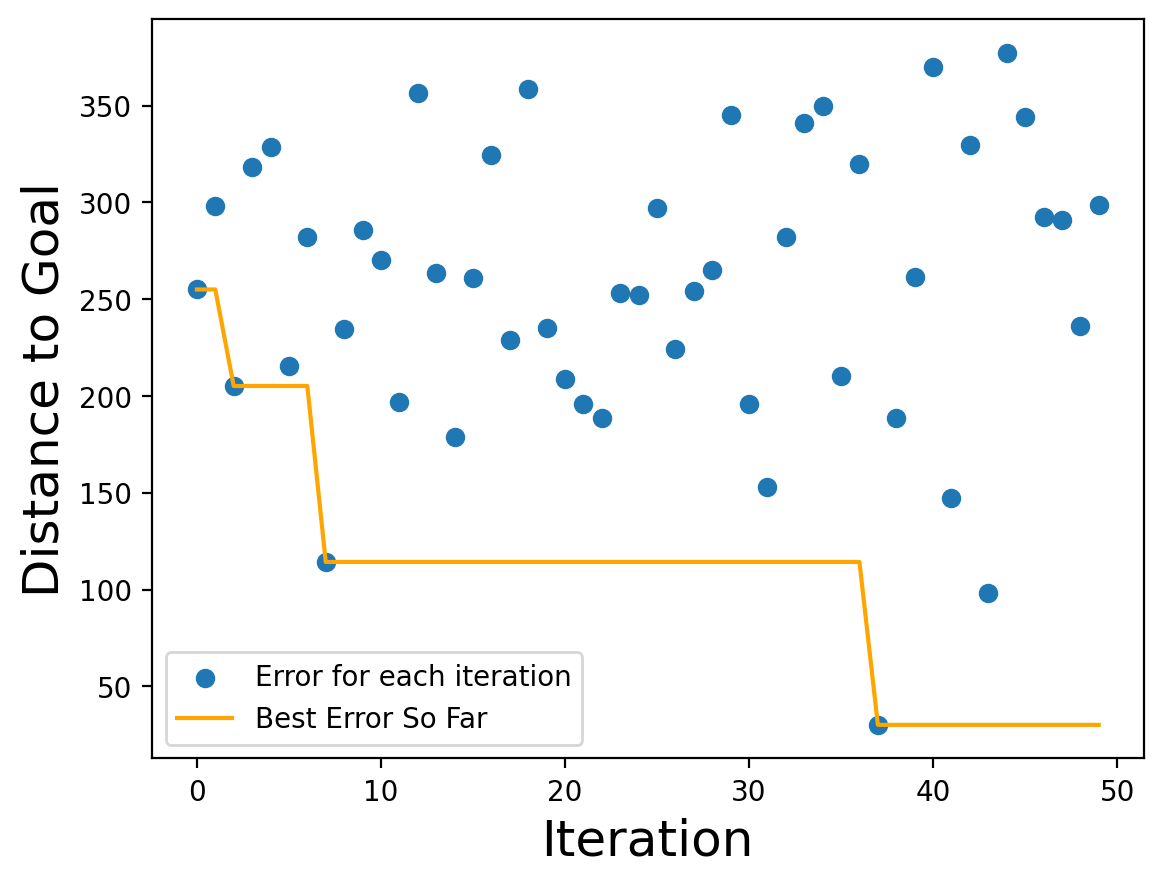

In [4]:
import matplotlib.pyplot as plt
# Plot error for each iteration
plt.scatter(range(len(error_values)), error_values, label="Error for each iteration")

# Calculate best error so far
best_error_so_far = 1000
best_errors = []
for value in error_values:
    if value < best_error_so_far:
        best_error_so_far = value
    best_errors.append(best_error_so_far)
    
# Plot best error so far
plt.plot(best_errors, label="Best Error So Far", color="orange")
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('Distance to Goal', fontsize=18)
plt.legend()

**Task**: Run the above script a few times. How do the errors change? What happens when you increase the number of iterations?

## (2) Strategy: Grid

We will generate a 'grid' of RGB combinations, which we then measure and pick the best point.

Image you want to cook the best pizza, but you don't know for how long you should put the pizza in the oven (e.g. at 200 Celsius). It is most likely somehwere between 10 and 15 minutes. If we have 6 pizzas, we can just put in a pizza for each 10, 11, 12, 13, 14 and 15 minutes and then test the taste. 

That's a grid: We have a lower (10) and upper (15) bound and a limited number of experiments we can run in between (6 pizzas). If we evenly space them, we get the following grid: 10, 11, 12, 13, 14, 15.

For our SDL4Kids, we have 3 variables R, G and B instead of 'minutes in the oven'. For example, we can create a grid with 3 steps for each variable. That would be 3 * 3 * 3 = 27 experiments to run. The following code generates such a grid:

In [5]:
grid_steps = 3
red = np.linspace(0, 255, grid_steps)
green = np.linspace(0, 255, grid_steps)
blue = np.linspace(0, 255, grid_steps)

grid_combinations = []
for r in red:
    for g in green:
        for b in blue:
            combination = (r,g,b)
            grid_combinations.append(combination)
grid_combinations

[(0.0, 0.0, 0.0),
 (0.0, 0.0, 127.5),
 (0.0, 0.0, 255.0),
 (0.0, 127.5, 0.0),
 (0.0, 127.5, 127.5),
 (0.0, 127.5, 255.0),
 (0.0, 255.0, 0.0),
 (0.0, 255.0, 127.5),
 (0.0, 255.0, 255.0),
 (127.5, 0.0, 0.0),
 (127.5, 0.0, 127.5),
 (127.5, 0.0, 255.0),
 (127.5, 127.5, 0.0),
 (127.5, 127.5, 127.5),
 (127.5, 127.5, 255.0),
 (127.5, 255.0, 0.0),
 (127.5, 255.0, 127.5),
 (127.5, 255.0, 255.0),
 (255.0, 0.0, 0.0),
 (255.0, 0.0, 127.5),
 (255.0, 0.0, 255.0),
 (255.0, 127.5, 0.0),
 (255.0, 127.5, 127.5),
 (255.0, 127.5, 255.0),
 (255.0, 255.0, 0.0),
 (255.0, 255.0, 127.5),
 (255.0, 255.0, 255.0)]

The following loop evaluates each grid combination:

In [6]:
import random
import numpy as np
import cv2

# Create a blank image
width, height = 800, 400
image = np.zeros((height, width, 3), dtype=np.uint8)

# Create a named window for display
cv2.namedWindow("Live Image", cv2.WINDOW_NORMAL)
cv2.startWindowThread()

# Define font properties for displaying text
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.8
font_color = (255, 255, 255)  # White color

# Define the goal color
goal_color = (255, 0, 0) 

# Create an empty list to store the loss values
error_values = []

# Main loop
max_iterations = len(grid_combinations)  # Set the desired number of iterations

candidate_color = grid_combinations[0]

for iteration, grid_combination in enumerate(grid_combinations):
    # STEP 1: Synthesis
    # Update the live image with the current color
    image[:, :] = tuple(reversed(candidate_color))
    
    # Display the image
    cv2.imshow("Live Image", image)
    
    # STEP 2: Characterisation
    
    # Measure the color with the Microbit: We will do this eventually
    #rgb_measurement = characterise()  
    #rgb_measurement = tuple(reversed(rgb_measurement))
    
    # Measure the color by just pretending candidate_color being the measurement 
    rgb_measurement = candidate_color
    
    # STEP 3: Planning
    
    # Calculate the loss between the goal color and the current color
    error = calculate_error(goal_color, rgb_measurement)

    # Add the loss value to the list
    error_values.append(error)    

    # Add text information to the image
    text = f"Iteration: {iteration + 1}"
    cv2.putText(image, text, (10, 30), font, font_scale, font_color, 2)

    # Plot a subplot for the goal color
    # subplot_x = num_iterations * (width // (max_iterations + 1))
    subplot_x = width // (max_iterations + 1)
    subplot_width = width // (max_iterations + 1)
    cv2.rectangle(image, (subplot_x, 60), (subplot_x + subplot_width, height - 60), tuple(reversed(goal_color)), -1)

    # Add text for the error
    error_text = f"Loss: {error:.2f}"
    cv2.putText(image, error_text, (10, height - 10), font, font_scale, font_color, 2)

    # Draw the graph of error values
    if len(error_values) > 1:
        for i in range(1, len(error_values)):
            x1 = (i - 1) * (width // max_iterations)
            y1 = height - int(error_values[i - 1] * (height - 60) / max(error_values))
            x2 = i * (width // max_iterations)
            y2 = height - int(error_values[i] * (height - 60) / max(error_values))
            cv2.line(image, (x1, y1), (x2, y2), (255, 255, 255), 2)

    # Increment the iteration counter
    cv2.imshow("Live Image", image)
    cv2.waitKey(50)  # Adjust the wait time (in milliseconds) as needed
    
    # Generate a new candidate color, for now we will pick one randomly
    candidate_color = grid_combination
    
# Close the window after the desired number of iterations
cv2.waitKey(1)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

Let's plot the error values for each grid combination. Notice the pattern a grid creates.

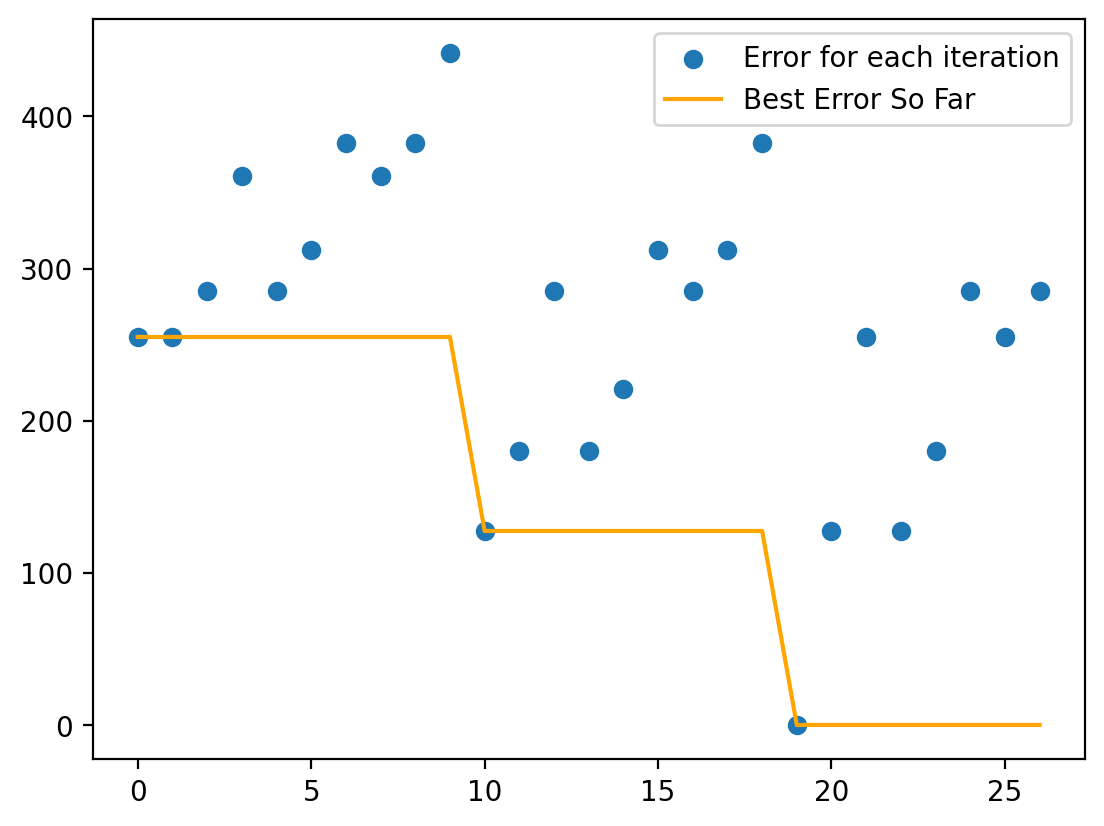

In [7]:
import matplotlib.pyplot as plt
# Plot error for each iteration
plt.scatter(range(len(error_values)), error_values, label="Error for each iteration")

# Calculate best error so far
best_error_so_far = 1000
best_errors = []
for value in error_values:
    if value < best_error_so_far:
        best_error_so_far = value
    best_errors.append(best_error_so_far)
    
# Plot best error so far
plt.plot(best_errors, label="Best Error So Far", color="orange")
plt.legend()

**Question**: Which RGB combination was closest to our goal color?

*Solution*: Check the loss graph for the combination with the smallest loss, i.e. it is closest to our goal color.

In [ ]:
iteration_with_smallest_error = error_values.index(min(error_values))-1 # Index of the iteration with the smallest loss
print(f"The best candidate is iteration {iteration_with_smallest_error} with RGB={grid_combinations[iteration_with_smallest_error]}")

## (3) Strategy: Bayesian Optimisation 

**Goal**: With **Bayesian Optimisation**, we build a statistical model for decision making, i.e. using statistics to steer our search. 

**Warning**: Bayesian Optimiastion is by far the most complicated topic in this tutorial. If you do not understand it at first, that's perfectly normal. Just make sure you run the code properly!


The *random* strategy is a good baseline set ourselves as a standard to beat. If our search is not better than *random* then, we should just randomly experiment. With a *grid* search, we are more structured in our search, but the best experiment can still easily sleep in between the grid points.

With **Bayesian Optimisation**, we build a statistical model for decision making, i.e. using statistics to steer our search. This model will represent the behaviour of our RGB color. In Material Science, it can for example represent the relationships between water content and concrete strength.

We can ask this model for the next *most informative* combination to test, collect the data, update the model and repeat.

In [8]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf
from botorch.models.transforms.input import Normalize
from botorch.models.transforms.outcome import Standardize

/opt/homebrew/Caskroom/miniforge/base/envs/SDL4Kids/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
import pandas as pd
def calculate_candidate(samples):
    train_X = samples[["R","G","B"]]
    train_Y = samples[["error"]]

    train_X = torch.tensor(train_X.to_numpy(dtype=np.float64))
    train_Y = torch.tensor(-1*train_Y.to_numpy(dtype=np.float64))

    gp = SingleTaskGP(train_X, train_Y, input_transform=Normalize(d=train_X.shape[-1]), outcome_transform=Standardize(m=train_Y.shape[-1]),)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)

    from botorch.acquisition import UpperConfidenceBound
    UCB = UpperConfidenceBound(gp, beta=0.1)
    
    from botorch.optim import optimize_acqf
    bounds = torch.stack([torch.zeros(3), torch.ones(3)*255])
    candidate, acq_value = optimize_acqf(
        UCB, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
    )
    candidate = candidate[0]
    candidate = {"R": candidate[0], "G": candidate[1], "B": candidate[2]}
    return candidate

In [11]:
import random
import numpy as np
import cv2

# Create a blank image
width, height = 800, 400
image = np.zeros((height, width, 3), dtype=np.uint8)

# Create a named window for display
cv2.namedWindow("Live Image", cv2.WINDOW_NORMAL)
cv2.startWindowThread()

# Define font properties for displaying text
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.8
font_color = (255, 255, 255)  # White color

# Define the goal color
goal_color = (255,0,0) 

# Main loop
max_iterations = 25  # Set the desired number of iterations

# Let us set up a data table to record the data more structured
samples = pd.DataFrame(columns=['R', 'G', 'B', 'error', 'ID'])

candidate_color = (0,0,0) # Initial color

for iteration in range(max_iterations):
    print(f"---Iteration {iteration}")

    # STEP 1: Synthesis
    # Update the live image with the current color
    print(f"Synthesis:{candidate_color}")
    image[:, :] = tuple(reversed(candidate_color))
    
    # Display the image
    cv2.imshow("Live Image", image)
    
    # STEP 2: Characterisation
    # Measure the color by just plugging it in
    rgb_measurement = candidate_color
    print(f"Characterisation:{rgb_measurement}")
    
    # STEP 3: Planning
    # Calculate the loss between the goal color and the current color
    error = calculate_error(goal_color, rgb_measurement)
    print(f"Error:{error}")

    # Add the sample to the data table
    new_sample = pd.DataFrame({"R":rgb_measurement[0], "G":rgb_measurement[1], "B":rgb_measurement[2], "ID":iteration, "error":error}, index=[iteration])
    samples = pd.concat([samples, new_sample], axis=0, ignore_index=True)

    candidate = calculate_candidate(samples)
    candidate_color = (candidate['R'].item(), candidate['G'].item(), candidate['B'].item())
    print(f"Planning: Candidate:{candidate_color}")
    
    # Add text information to the image
    text = f"Iteration: {iteration + 1}"
    cv2.putText(image, text, (10, 30), font, font_scale, font_color, 2)

    # Plot a subplot for the goal color
    # subplot_x = num_iterations * (width // (max_iterations + 1))
    subplot_x = width // (max_iterations + 1)
    subplot_width = 50
    cv2.rectangle(image, (subplot_x, 60), (subplot_x + subplot_width, height - 60), tuple(reversed(goal_color)), -1)

    # Add text for the error
    error_text = f"Error: {error:.2f}"
    cv2.putText(image, error_text, (10, height - 10), font, font_scale, font_color, 2)

    error_values = list(samples['error'].to_numpy())    # Draw the graph of error values
    if len(error_values) > 1:
        for i in range(1, len(error_values)):
            x1 = (i - 1) * (width // max_iterations)
            y1 = height - int(error_values[i - 1] * (height - 60) / max(error_values))
            x2 = i * (width // max_iterations)
            y2 = height - int(error_values[i] * (height - 60) / max(error_values))
            cv2.line(image, (x1, y1), (x2, y2), (255, 255, 255), 2)

    # Increment the iteration counter
    cv2.imshow("Live Image", image)
    cv2.waitKey(100)  # Adjust the wait time (in milliseconds) as needed
    
# Close the window after the desired number of iterations
cv2.waitKey(1)
cv2.destroyAllWindows()
cv2.waitKey(1)

---Iteration 0
Synthesis:(0, 0, 0)
Characterisation:(0, 0, 0)
Error:255.0
Planning: Candidate:(31.162668228149414, 152.0714569091797, 148.8514862060547)
---Iteration 1
Synthesis:(31.162668228149414, 152.0714569091797, 148.8514862060547)
Characterisation:(31.162668228149414, 152.0714569091797, 148.8514862060547)
Error:308.84566379823644


/opt/homebrew/Caskroom/miniforge/base/envs/SDL4Kids/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Planning: Candidate:(0.0, 0.0, 19.109872817993164)
---Iteration 2
Synthesis:(0.0, 0.0, 19.109872817993164)
Characterisation:(0.0, 0.0, 19.109872817993164)
Error:255.71505086545037
Planning: Candidate:(0.0, 15.991660118103027, 5.554281711578369)
---Iteration 3
Synthesis:(0.0, 15.991660118103027, 5.554281711578369)
Characterisation:(0.0, 15.991660118103027, 5.554281711578369)
Error:255.56131013646117
Planning: Candidate:(0.0, 0.0, 2.8907148838043213)
---Iteration 4
Synthesis:(0.0, 0.0, 2.8907148838043213)
Characterisation:(0.0, 0.0, 2.8907148838043213)
Error:255.01638424332552
Planning: Candidate:(210.62525939941406, 162.1056671142578, 110.42650604248047)
---Iteration 5
Synthesis:(210.62525939941406, 162.1056671142578, 110.42650604248047)
Characterisation:(210.62525939941406, 162.1056671142578, 110.42650604248047)
Error:201.100418076835
Planning: Candidate:(222.4980010986328, 162.7130889892578, 107.8037338256836)
---Iteration 6
Synthesis:(222.4980010986328, 162.7130889892578, 107.8037338

-1

Let's plot the error curve for Bayesian Optimisation. Notice how fast BO finds the best RGB combination. 

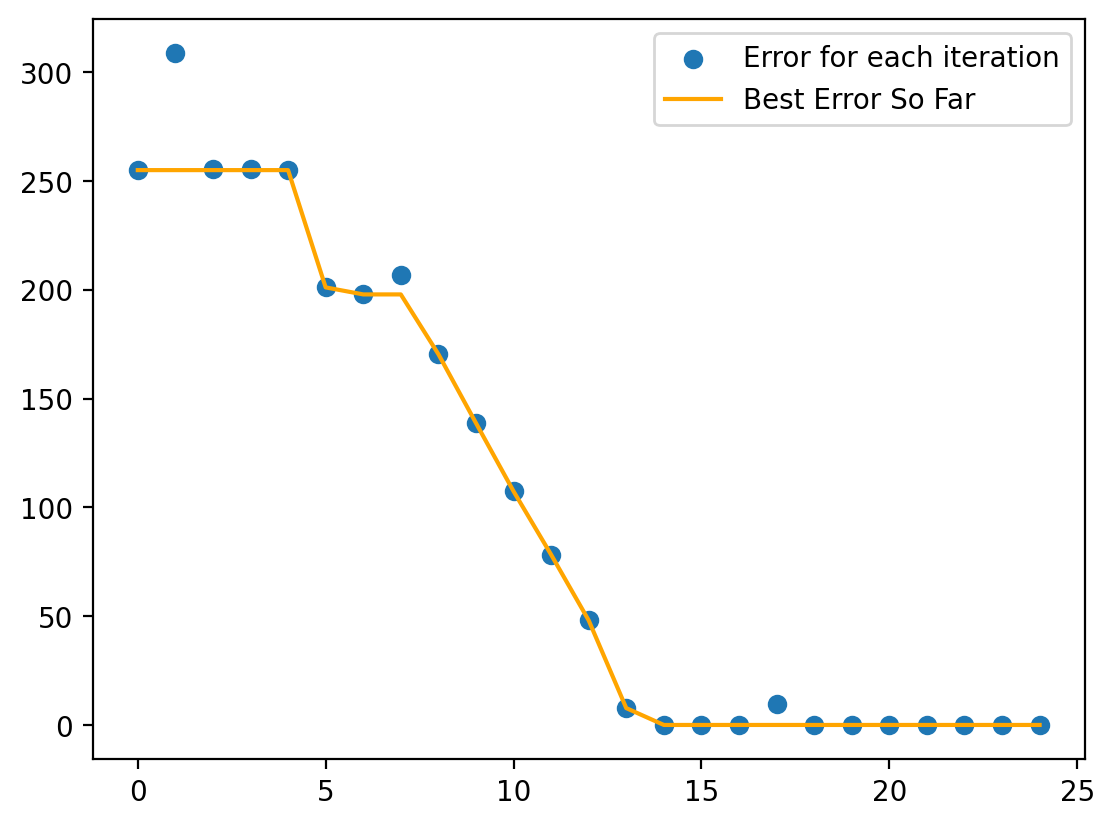

In [12]:
import matplotlib.pyplot as plt
# Plot error for each iteration
plt.scatter(range(len(error_values)), error_values, label="Error for each iteration")

# Calculate best error so far
best_error_so_far = 999999
best_errors = []
for value in error_values:
    if value < best_error_so_far:
        best_error_so_far = value
    best_errors.append(best_error_so_far)
    
# Plot best error so far
plt.plot(best_errors, label="Best Error So Far", color="orange")
plt.legend()

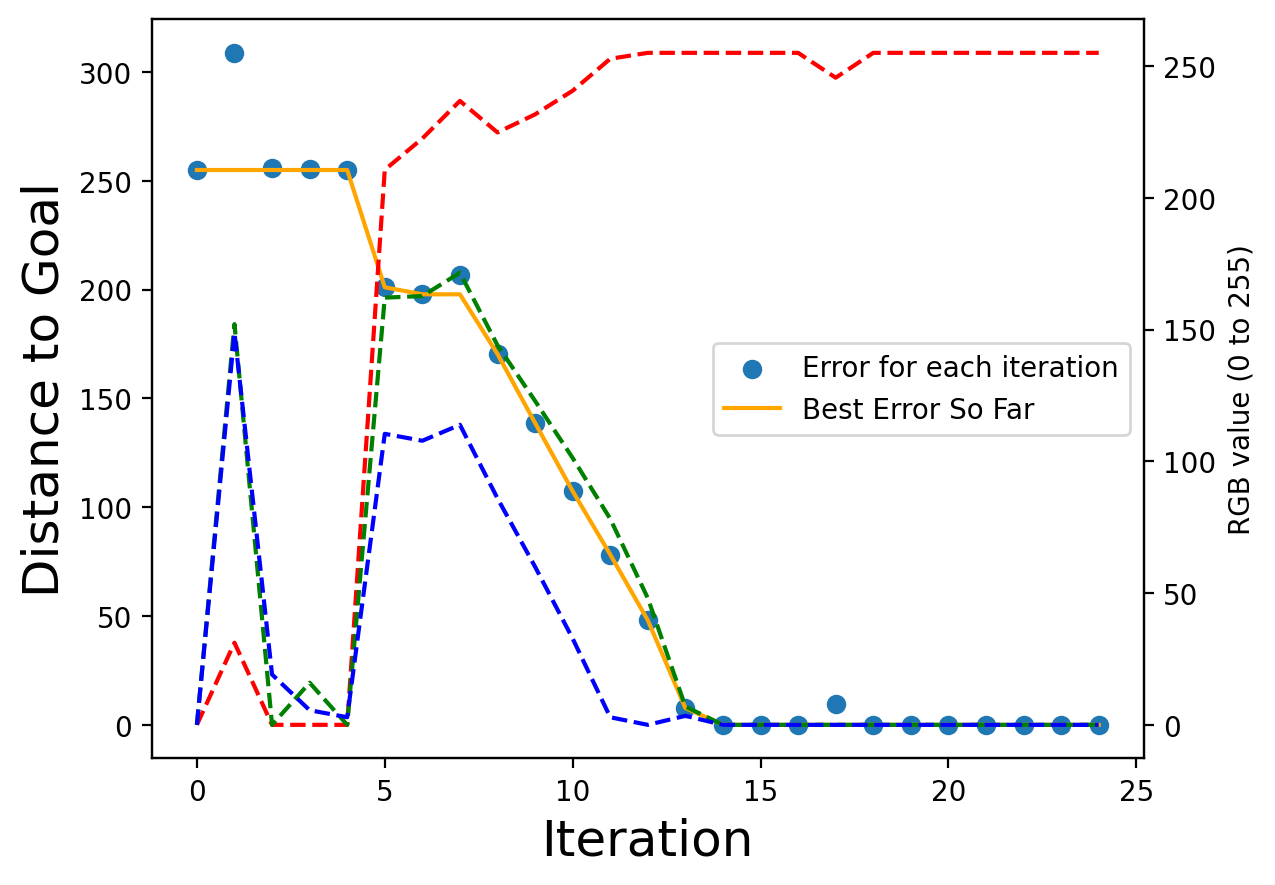

In [13]:
import matplotlib.pyplot as plt
# Plot error for each iteration
plt.scatter(range(len(error_values)), error_values, label="Error for each iteration")

# Calculate best error so far
best_error_so_far = 1000
best_errors = []
for value in error_values:
    if value < best_error_so_far:
        best_error_so_far = value
    best_errors.append(best_error_so_far)
    
# Plot best error so far
plt.plot(best_errors, label="Best Error So Far", color="orange")
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('Distance to Goal', fontsize=18)
plt.legend(loc = "center right")
ax = plt.gca()
secax = ax.twinx() 
secax.set_ylabel('RGB value (0 to 255)')
secax.plot(samples['R'], color='red', linestyle='dashed')
secax.plot(samples['G'], color='green', linestyle='dashed')
secax.plot(samples['B'], color='blue', linestyle='dashed')


**Task**: Change the goal color and see if that makes a difference to the speed of Bayesian Optimisation.


## (4) Bayesian Optimisation with Microbit measurements

**Goal**: We will now use real measurements from the enviro:bit to complete the close the loop of our SDL setup.

We have already look in detail how to do measurements with the microbit in the notebook for Step 2 on Characterisation. Make sure you have worked through that before.

In [14]:
import serial

In [15]:
!ls /dev/cu.*

/dev/cu.Bluetooth-Incoming-Port /dev/cu.ZeitlersBoseQC35II
/dev/cu.RoastBeats              /dev/cu.usbmodem1102


In [17]:
ser = serial.Serial()
ser = serial.Serial("/dev/cu.usbmodem1102",115200, timeout=0.1)

In [18]:
def characterise():
    import time
    valid = False
    max_num_tries = 25
    num_tries = 0
    while not valid:
        try:
            ser.flushInput()
            ser.write(b",")
            serial_data = str(ser.readline().decode('utf8')).rstrip()
            rgb = tuple([int(value) for value in serial_data.split("-")])
            # Measurement needs three entries
            if len(rgb) != 3:
                print(f"Measurement did not containt 3 RGB values:{rgb}")
                raise Exception()
            if not np.all([0 <= x <= 255 for x in rgb]):
                print(f"Measurement outside valid range [0,255]:{rgb}")
                raise Exception()
            valid = True
        except Exception as err:
            print(f"Unexpected {err=}, {type(err)=}")
            print("Measurement invalid, will try again")
            if num_tries > max_num_tries:
                print("Please check connection. Maximum number of tries exceeded. There seems to be a fatal error.")
                break
            num_tries = num_tries + 1
    print(f"New RGB Measurement: {rgb}")
    time.sleep(0.4)
    return rgb

In [19]:
characterise()

New RGB Measurement: (78, 106, 106)


(78, 106, 106)

**Warning**: Make 100% sure that you disconnected your Microbit from Google Chrome before continuing. Otherwise, Google Chrome will interfere with the serial connection and you cannot request values

In [20]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf
from botorch.models.transforms.input import Normalize
from botorch.models.transforms.outcome import Standardize

In [21]:
import pandas as pd
def calculate_candidate(samples):
    train_X = samples[["R","G","B"]]
    train_Y = samples[["error"]]

    train_X = torch.tensor(train_X.to_numpy(dtype=np.float64))
    train_Y = torch.tensor(-1*train_Y.to_numpy(dtype=np.float64))

    gp = SingleTaskGP(train_X, train_Y, input_transform=Normalize(d=train_X.shape[-1]), outcome_transform=Standardize(m=train_Y.shape[-1]),)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)

    from botorch.acquisition import UpperConfidenceBound
    UCB = UpperConfidenceBound(gp, beta=0.1)
    
    from botorch.optim import optimize_acqf
    bounds = torch.stack([torch.zeros(3), torch.ones(3)*255])
    candidate, acq_value = optimize_acqf(
        UCB, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
    )
    candidate = candidate[0]
    candidate = {"R": candidate[0], "G": candidate[1], "B": candidate[2]}
    return candidate

In [22]:
import random
import numpy as np
import cv2

# Create a blank image
width, height = 800, 400
image = np.zeros((height, width, 3), dtype=np.uint8)

# Create a named window for display
cv2.namedWindow("Live Image", cv2.WINDOW_NORMAL)
cv2.startWindowThread()

# Define font properties for displaying text
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.8
font_color = (255, 255, 255)  # White color

# Define the goal color
goal_color = (255,0,0) 

# Main loop
max_iterations = 50  # Set the desired number of iterations

# Let us set up a data table to record the data more structured
samples = pd.DataFrame(columns=['R', 'G', 'B', 'error', 'ID'])

candidate_color = (0,0,0) # Initial color

for iteration in range(max_iterations):
    print(f"---Iteration {iteration}")

    # STEP 1: Synthesis
    # Update the live image with the current color
    print(f"Synthesis:{candidate_color}")
    image[:, :] = tuple(reversed(candidate_color))
    
    # Display the image
    cv2.imshow("Live Image", image)
    
    # STEP 2: Characterisation
    
    # Measure the color with the Microbit: We will do this eventually
    rgb_measurement = characterise()  
    print(f"Characterisation:{rgb_measurement}")
    #rgb_measurement = (rgb_measurement[0]+np.random.normal(1),rgb_measurement[1]+np.random.normal(1),rgb_measurement[2]+np.random.normal(1))
    
    # STEP 3: Planning
    
    # Calculate the loss between the goal color and the current color
    error = calculate_error(goal_color, rgb_measurement)
    print(f"Error:{error}")

    # Add the sample to the data table
    new_sample = pd.DataFrame({"R":rgb_measurement[0], "G":rgb_measurement[1], "B":rgb_measurement[2], "ID":iteration, "error":error}, index=[iteration])
    samples = pd.concat([samples, new_sample], axis=0, ignore_index=True)

    candidate = calculate_candidate(samples)
    candidate_color = (candidate['R'].item(), candidate['G'].item(), candidate['B'].item())
    print(f"Planning: Candidate:{candidate_color}")
    
    # Add text information to the image
    text = f"Iteration: {iteration + 1}"
    cv2.putText(image, text, (10, 30), font, font_scale, font_color, 2)

    # Plot a subplot for the goal color
    # subplot_x = num_iterations * (width // (max_iterations + 1))
    subplot_x = width // (max_iterations + 1)
    subplot_width = 50
    cv2.rectangle(image, (subplot_x, 60), (subplot_x + subplot_width, height - 60), tuple(reversed(goal_color)), -1)

    # Add text for the error
    error_text = f"Error: {error:.2f}"
    cv2.putText(image, error_text, (10, height - 10), font, font_scale, font_color, 2)

    error_values = list(samples['error'].to_numpy())    # Draw the graph of error values
    if len(error_values) > 1:
        for i in range(1, len(error_values)):
            x1 = (i - 1) * (width // max_iterations)
            y1 = height - int(error_values[i - 1] * (height - 60) / max(error_values))
            x2 = i * (width // max_iterations)
            y2 = height - int(error_values[i] * (height - 60) / max(error_values))
            cv2.line(image, (x1, y1), (x2, y2), (255, 255, 255), 2)

    # Increment the iteration counter
    cv2.imshow("Live Image", image)
    cv2.waitKey(100)  # Adjust the wait time (in milliseconds) as needed
    
# Close the window after the desired number of iterations
cv2.waitKey(1)
cv2.destroyAllWindows()
cv2.waitKey(1)

---Iteration 0
Synthesis:(0, 0, 0)
New RGB Measurement: (102, 111, 109)
Characterisation:(102, 111, 109)
Error:218.19945004513644
Planning: Candidate:(225.4900360107422, 17.842376708984375, 230.45748901367188)
---Iteration 1
Synthesis:(225.4900360107422, 17.842376708984375, 230.45748901367188)
New RGB Measurement: (105, 111, 108)
Characterisation:(105, 111, 108)
Error:215.60380330597138
Planning: Candidate:(46.14500427246094, 223.41049194335938, 111.17643737792969)
---Iteration 2
Synthesis:(46.14500427246094, 223.41049194335938, 111.17643737792969)
New RGB Measurement: (140, 121, 127)
Characterisation:(140, 121, 127)
Error:209.74985101305793
Planning: Candidate:(176.0456085205078, 131.99493408203125, 109.73387145996094)
---Iteration 3
Synthesis:(176.0456085205078, 131.99493408203125, 109.73387145996094)
New RGB Measurement: (124, 58, 113)
Characterisation:(124, 58, 113)
Error:182.46643526961336
Planning: Candidate:(195.34286499023438, 108.61309051513672, 87.2735366821289)
---Iteration 

Characterisation:(202, 46, 51)
Error:86.75252157718529
Planning: Candidate:(240.11077880859375, 27.0694522857666, 31.23809814453125)
---Iteration 33
Synthesis:(240.11077880859375, 27.0694522857666, 31.23809814453125)
New RGB Measurement: (201, 46, 51)
Characterisation:(201, 46, 51)
Error:87.36704184073076
Planning: Candidate:(240.1693115234375, 27.07993507385254, 31.266977310180664)
---Iteration 34
Synthesis:(240.1693115234375, 27.07993507385254, 31.266977310180664)
New RGB Measurement: (202, 46, 51)
Characterisation:(202, 46, 51)
Error:86.75252157718529
Planning: Candidate:(240.45263671875, 27.102066040039062, 31.28180503845215)
---Iteration 35
Synthesis:(240.45263671875, 27.102066040039062, 31.28180503845215)
New RGB Measurement: (201, 47, 52)
Characterisation:(201, 47, 52)
Error:88.48163651289458
Planning: Candidate:(240.196533203125, 26.472543716430664, 30.726654052734375)
---Iteration 36
Synthesis:(240.196533203125, 26.472543716430664, 30.726654052734375)
New RGB Measurement: (201

-1

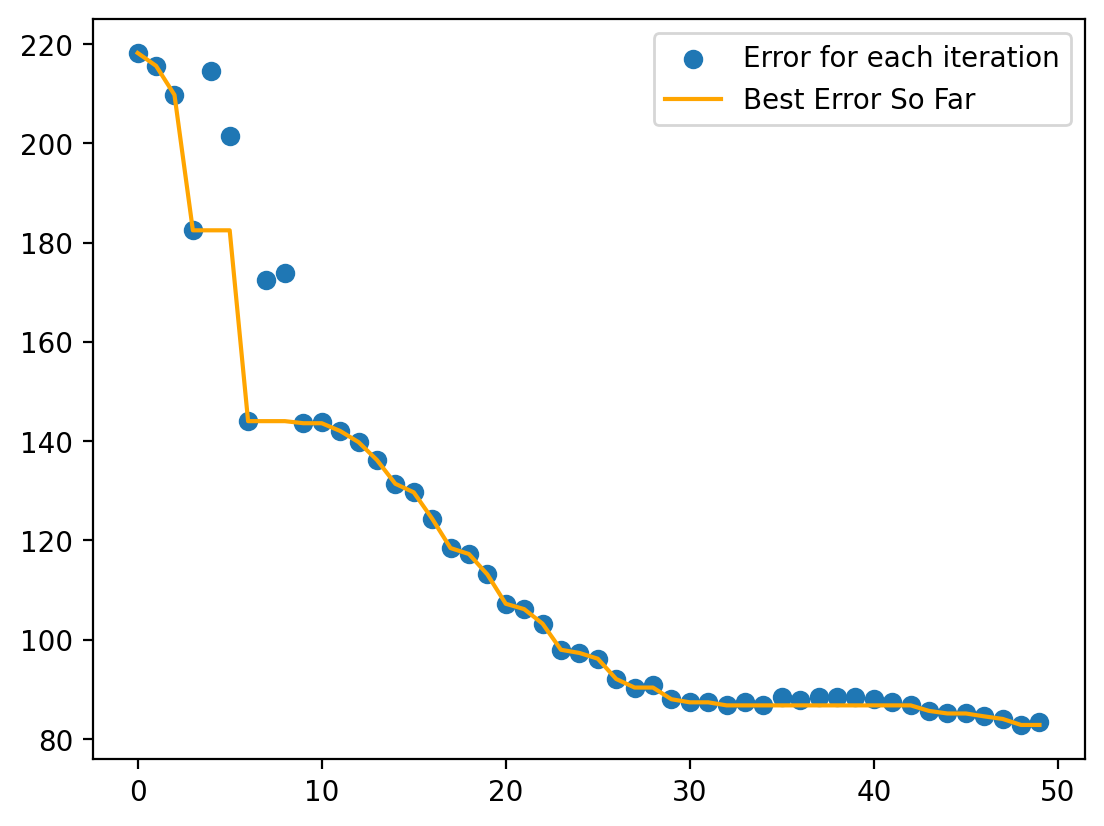

In [23]:
import matplotlib.pyplot as plt
# Plot error for each iteration
plt.scatter(range(len(error_values)), error_values, label="Error for each iteration")

# Calculate best error so far
best_error_so_far = 1000
best_errors = []
for value in error_values:
    if value < best_error_so_far:
        best_error_so_far = value
    best_errors.append(best_error_so_far)
    
# Plot best error so far
plt.plot(best_errors, label="Best Error So Far", color="orange")
plt.legend()

Let's also plot the RGB colors with it.

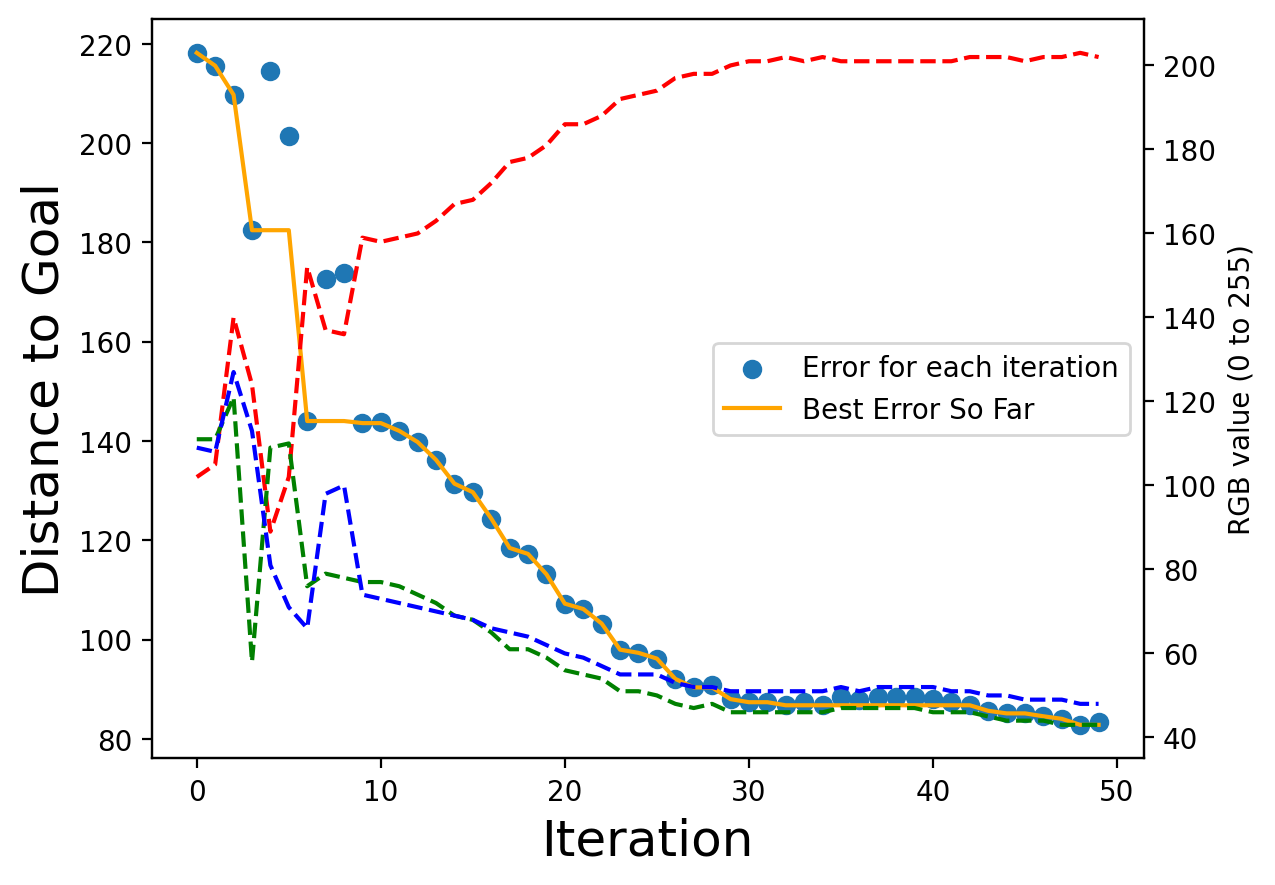

In [24]:
import matplotlib.pyplot as plt
# Plot error for each iteration
plt.scatter(range(len(error_values)), error_values, label="Error for each iteration")

# Calculate best error so far
best_error_so_far = 1000
best_errors = []
for value in error_values:
    if value < best_error_so_far:
        best_error_so_far = value
    best_errors.append(best_error_so_far)
    
# Plot best error so far
plt.plot(best_errors, label="Best Error So Far", color="orange")
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('Distance to Goal', fontsize=18)
plt.legend(loc = "center right")
ax = plt.gca()
secax = ax.twinx() 
secax.set_ylabel('RGB value (0 to 255)')
secax.plot(samples['R'], color='red', linestyle='dashed')
secax.plot(samples['G'], color='green', linestyle='dashed')
secax.plot(samples['B'], color='blue', linestyle='dashed')


**Task**: Run the SDL loop a few times. Change the distance of how close the microbit color sensor is to your screen. Does it impact the speed of convergence? Is there a distance where the sensor does not reliably measure the color anymore?

## (5) Congratulations! 

### You just ran your first closed-loop self-driving laboratory. In Step 1, 2 and 3, you learned how to do:
### 1. Synthesis: *Generating the material: a color on your screen (RGB)*
### 2. Charactersiation: *Measuring the material: the color on your screen (in RGB)*
### 3. Planning: *Choosing the next experiment: randomly, with a grid or with Bayesian Optimisation*